In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from time import time
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('..')

import isolation
import sample_players
import run_match
import my_baseline_player as custom
import book as b

from multiprocessing.pool import ThreadPool as Pool

Populating the interactive namespace from numpy and matplotlib


/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Constant parameteres
time_limit = 150
depth = 4
full_search_depth = 2
matches_per_opening = 3

# Create the agents that will play
agent_names = ('CustomPlayer1', 'CustomPlayer2')
agent1 = isolation.Agent(custom.CustomPlayer, agent_names[0])
agent2 = isolation.Agent(custom.CustomPlayer, agent_names[1])
agents = (agent1, agent2)

# Get the initial states
root = isolation.isolation.Isolation()
opening_states = list(b.get_full_states(root, depth=full_search_depth))

# Generate the matches
matches = [(agents, state, time_limit, match_id) 
           for match_id, state in enumerate(opening_states)]
matches = matches * 3
print('Generated {} matches.'.format(len(matches)))

Generated 29403 matches.


In [3]:
num_processes = 4
batch_size = 100
batch_num_file = 'batch_num.txt'

# Small test for debugging
# matches = matches[:100]

# Create or load the book
book = b.load_latest_book(depth=depth)

# Make some batches to save the results once in a while
x = matches
batches = [x[i*batch_size:(i+1)*batch_size] 
           for i in range(len(x) // batch_size + (len(x) % batch_size != 0))]

# Get only the unprocessed batches
if os.path.exists(batch_num_file):
    with open(batch_num_file, 'r') as file:
        last_batch = int(file.read())
else:
    last_batch = -1

# Now fill the book!
pool = Pool(num_processes)

for batch_num in range(last_batch + 1, len(batches)):
    tic = time.time()
    batch = batches[batch_num]
    print('Processing batch {} of {}'.format(batch_num, len(batches)))
    for result in pool.imap_unordered(isolation.play, batch):
        winner, game_history, match_id = result
        # print('Results for match {}: {} wins.'.format(match_id, winner.name))
        _, state, _, _ = matches[match_id]
        if state.locs[1] is not None:
            game_history.insert(0,state.locs[1])
        if state.locs[0] is not None:
            game_history.insert(0,state.locs[0])
        root = isolation.isolation.Isolation()
        b.process_game_history(root,
                               game_history, 
                               book,
                               agent_names.index(winner.name),
                               active_player=state.ply_count % 2,
                               depth=depth)
    toc = time.time()
    print('Batch time {} seconds.'.format((toc-tic)))
    b.save_book(book)
    with open(batch_num_file, 'w') as file:
        file.write(str(batch_num))
    b.remove_old_books()

Processing batch 1 of 295
Batch time 288.5851950645447 seconds.
Saving: book2018-06-18_14S48S13.159146.pkl
rm book2018-06-18_13S59S32.105677.pkl
Processing batch 2 of 295
Batch time 291.7291650772095 seconds.
Saving: book2018-06-18_14S53S05.682961.pkl
rm book2018-06-18_14S48S13.159146.pkl
Processing batch 3 of 295
Batch time 282.66441011428833 seconds.
Saving: book2018-06-18_14S57S48.988173.pkl
rm book2018-06-18_14S53S05.682961.pkl
Processing batch 4 of 295
Batch time 291.0588049888611 seconds.
Saving: book2018-06-18_15S02S40.704854.pkl
rm book2018-06-18_14S57S48.988173.pkl
Processing batch 5 of 295
Batch time 287.6183879375458 seconds.
Saving: book2018-06-18_15S07S29.161021.pkl
rm book2018-06-18_15S02S40.704854.pkl
Processing batch 6 of 295
Batch time 288.0019919872284 seconds.
Saving: book2018-06-18_15S12S17.788571.pkl
rm book2018-06-18_15S07S29.161021.pkl
Processing batch 7 of 295
Batch time 276.0004699230194 seconds.
Saving: book2018-06-18_15S16S54.397698.pkl
rm book2018-06-18_15S1

Process Process-146474:
Traceback (most recent call last):
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 255, in _bootstrap
    util._exit_function()
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/multiprocessing/queues.py", line 191, in _finalize_join
    thread.join()
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/threading.py", line 1054, in join
    self._wait_for_tstate_lock(

KeyboardInterrupt: 

In [4]:
sum(abs(value[0]) for value in book.values())

19665

In [5]:
sum(abs(value[1]) for value in book.values())

31187

In [6]:
29403*34 / (10*3600)  # Estimated time in hours

27.7695

In [7]:
import pandas as pd

v = pd.Series([v[0] for v in book.values()])

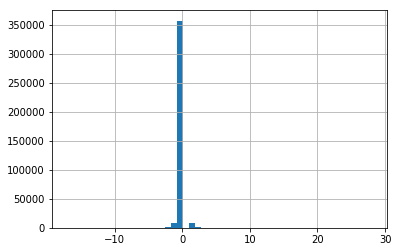

In [8]:
v.hist(bins=50)

In [9]:
v.describe()

count    374097.000000
mean          0.000730
std           0.306768
min         -17.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
dtype: float64

In [10]:
v.min()

-17

In [11]:
worst = min(((k, v) for k, v in book.items()), key=lambda x: x[1][0])
worst[0]

(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
 48)

In [12]:
from isolation.isolation import Isolation
state = Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None))

print(isolation.DebugState.from_state(state.result(57)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   | 1 |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



What about the other symmetrical ones

In [13]:
s1 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 56)
s2 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 58)
s3 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 70)
s4 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 44)

In [14]:
book[s1]

[6, 118]

In [15]:
book[s2]

[6, 118]

In [16]:
book[s3]

[-4, 92]

In [17]:
book[s4]

[-4, 92]

### I think I have ply_count=1,2,3,4 in the book but not ply_count=0

In [18]:
len(book.items())

374097

### Idea: show a heat matrix for the initial move

In [19]:
first = {item:value[0] for item, value in book.items() if item[0].ply_count==0}

In [20]:
len(first)

99

In [21]:
first

{(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  0): 3,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  1): -3,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  2): -5,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  3): 25,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  4): 16,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  5): -2,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  6): 16,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  7): 25,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  8): -5,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  9): -3,
 (Isolation(board=415

In [22]:
pos_value = {key[1]:value for key,value in first.items()}
pos_value

{0: 3,
 1: -3,
 2: -5,
 3: 25,
 4: 16,
 5: -2,
 6: 16,
 7: 25,
 8: -5,
 9: -3,
 10: 3,
 13: 9,
 14: 0,
 15: 0,
 16: 3,
 17: -14,
 18: 8,
 19: -14,
 20: 3,
 21: 0,
 22: 0,
 23: 9,
 26: 10,
 27: -12,
 28: 6,
 29: 10,
 30: 5,
 31: 18,
 32: 5,
 33: 10,
 34: 6,
 35: -12,
 36: 10,
 39: 19,
 40: -17,
 41: -3,
 42: -4,
 43: 11,
 44: -4,
 45: 11,
 46: -4,
 47: -3,
 48: -17,
 49: 19,
 52: -14,
 53: 28,
 54: 4,
 55: 16,
 56: 6,
 57: 8,
 58: 6,
 59: 16,
 60: 4,
 61: 28,
 62: -14,
 65: 19,
 66: -17,
 67: -3,
 68: -4,
 69: 11,
 70: -4,
 71: 11,
 72: -4,
 73: -3,
 74: -17,
 75: 19,
 78: 10,
 79: -12,
 80: 6,
 81: 10,
 82: 5,
 83: 18,
 84: 5,
 85: 10,
 86: 6,
 87: -12,
 88: 10,
 91: 9,
 92: 0,
 93: 0,
 94: 3,
 95: -14,
 96: 8,
 97: -14,
 98: 3,
 99: 0,
 100: 0,
 101: 9,
 104: 3,
 105: -3,
 106: -5,
 107: 25,
 108: 16,
 109: -2,
 110: 16,
 111: 25,
 112: -5,
 113: -3,
 114: 3}

In [23]:
filled_vals = dict(zip(range(115),[0]*115))
filled_vals.update(pos_value)
filled_vals

{0: 3,
 1: -3,
 2: -5,
 3: 25,
 4: 16,
 5: -2,
 6: 16,
 7: 25,
 8: -5,
 9: -3,
 10: 3,
 11: 0,
 12: 0,
 13: 9,
 14: 0,
 15: 0,
 16: 3,
 17: -14,
 18: 8,
 19: -14,
 20: 3,
 21: 0,
 22: 0,
 23: 9,
 24: 0,
 25: 0,
 26: 10,
 27: -12,
 28: 6,
 29: 10,
 30: 5,
 31: 18,
 32: 5,
 33: 10,
 34: 6,
 35: -12,
 36: 10,
 37: 0,
 38: 0,
 39: 19,
 40: -17,
 41: -3,
 42: -4,
 43: 11,
 44: -4,
 45: 11,
 46: -4,
 47: -3,
 48: -17,
 49: 19,
 50: 0,
 51: 0,
 52: -14,
 53: 28,
 54: 4,
 55: 16,
 56: 6,
 57: 8,
 58: 6,
 59: 16,
 60: 4,
 61: 28,
 62: -14,
 63: 0,
 64: 0,
 65: 19,
 66: -17,
 67: -3,
 68: -4,
 69: 11,
 70: -4,
 71: 11,
 72: -4,
 73: -3,
 74: -17,
 75: 19,
 76: 0,
 77: 0,
 78: 10,
 79: -12,
 80: 6,
 81: 10,
 82: 5,
 83: 18,
 84: 5,
 85: 10,
 86: 6,
 87: -12,
 88: 10,
 89: 0,
 90: 0,
 91: 9,
 92: 0,
 93: 0,
 94: 3,
 95: -14,
 96: 8,
 97: -14,
 98: 3,
 99: 0,
 100: 0,
 101: 9,
 102: 0,
 103: 0,
 104: 3,
 105: -3,
 106: -5,
 107: 25,
 108: 16,
 109: -2,
 110: 16,
 111: 25,
 112: -5,
 113: -3,
 114: 

In [24]:
W = 11
x = list(filled_vals.values())
rows = [x[i*(W+2):(i+1)*(W+2)] 
           for i in range(len(x) // (W+2) + (len(x) % (W+2) != 0))]

In [25]:
rows

[[3, -3, -5, 25, 16, -2, 16, 25, -5, -3, 3, 0, 0],
 [9, 0, 0, 3, -14, 8, -14, 3, 0, 0, 9, 0, 0],
 [10, -12, 6, 10, 5, 18, 5, 10, 6, -12, 10, 0, 0],
 [19, -17, -3, -4, 11, -4, 11, -4, -3, -17, 19, 0, 0],
 [-14, 28, 4, 16, 6, 8, 6, 16, 4, 28, -14, 0, 0],
 [19, -17, -3, -4, 11, -4, 11, -4, -3, -17, 19, 0, 0],
 [10, -12, 6, 10, 5, 18, 5, 10, 6, -12, 10, 0, 0],
 [9, 0, 0, 3, -14, 8, -14, 3, 0, 0, 9, 0, 0],
 [3, -3, -5, 25, 16, -2, 16, 25, -5, -3, 3]]

In [26]:
for i in range(len(rows)-1):
    rows[i] =rows[i][:-2]
rows

[[3, -3, -5, 25, 16, -2, 16, 25, -5, -3, 3],
 [9, 0, 0, 3, -14, 8, -14, 3, 0, 0, 9],
 [10, -12, 6, 10, 5, 18, 5, 10, 6, -12, 10],
 [19, -17, -3, -4, 11, -4, 11, -4, -3, -17, 19],
 [-14, 28, 4, 16, 6, 8, 6, 16, 4, 28, -14],
 [19, -17, -3, -4, 11, -4, 11, -4, -3, -17, 19],
 [10, -12, 6, 10, 5, 18, 5, 10, 6, -12, 10],
 [9, 0, 0, 3, -14, 8, -14, 3, 0, 0, 9],
 [3, -3, -5, 25, 16, -2, 16, 25, -5, -3, 3]]

In [27]:
rows = np.array(rows)
rows

array([[  3,  -3,  -5,  25,  16,  -2,  16,  25,  -5,  -3,   3],
       [  9,   0,   0,   3, -14,   8, -14,   3,   0,   0,   9],
       [ 10, -12,   6,  10,   5,  18,   5,  10,   6, -12,  10],
       [ 19, -17,  -3,  -4,  11,  -4,  11,  -4,  -3, -17,  19],
       [-14,  28,   4,  16,   6,   8,   6,  16,   4,  28, -14],
       [ 19, -17,  -3,  -4,  11,  -4,  11,  -4,  -3, -17,  19],
       [ 10, -12,   6,  10,   5,  18,   5,  10,   6, -12,  10],
       [  9,   0,   0,   3, -14,   8, -14,   3,   0,   0,   9],
       [  3,  -3,  -5,  25,  16,  -2,  16,  25,  -5,  -3,   3]])

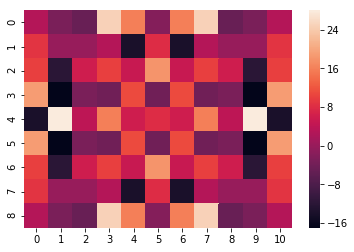

In [28]:
import seaborn as sns
sns.heatmap(rows)

In [29]:
second = {item:value[0] for item, value in book.items() if item[0].ply_count==1}

In [34]:
len(second)

9702

In [35]:
pd.Series(list(second.values())).describe()

count    9702.000000
mean       -0.004123
std         0.206041
min        -2.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
dtype: float64

In [36]:
third = {item:value[0] for item, value in book.items() if item[0].ply_count==2}

In [37]:
len(third)

55096

In [38]:
pd.Series(list(third.values())).describe()

count    55096.000000
mean         0.000726
std          0.085204
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

In [39]:
fourth = {item:value[0] for item, value in book.items() if item[0].ply_count==3}
len(fourth)

309200

In [40]:
pd.Series(list(fourth.values())).describe()

count    309200.000000
mean         -0.000032
std           0.017984
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [41]:
sum(np.array(list(third.values())) != 0)

400

In [42]:
sum(np.array(list(fourth.values())) != 0)

100